# FIVO in (Gaussian) LDS Notebook


In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random as jr
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import flax.linen as nn

# Import some ssm stuff.
from ssm.utils import Verbosity, random_rotation, possibly_disable_jit
from ssm.lds.models import GaussianLDS
import ssm.nn_util as nn_util
from ssm.inference.smc import smc, _plot_single_sweep
import ssm.utils as utils
import ssm.inference.fivo as fivo
import ssm.inference.proposals as proposals

# Set the default verbosity.
default_verbosity = Verbosity.DEBUG

In [2]:
# Define some plotting and printing scripts.
from colormap import hex2rgb
muted_colours_list = ["#4878D0", "#D65F5F", "#EE854A", "#6ACC64", "#956CB4",
                      "#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"]
muted_colours_list = np.asarray([hex2rgb(_c) for _c in muted_colours_list]) / 256
muted_colours_dict = {'blue':   muted_colours_list[0],
                      'red':    muted_colours_list[1],
                      'orange': muted_colours_list[2],
                      'green':  muted_colours_list[3],
                      'purple': muted_colours_list[4],
                      'brown':  muted_colours_list[5],
                      'pink':   muted_colours_list[6],
                      'gray':   muted_colours_list[7],
                      'yellow': muted_colours_list[8],
                      'eggsh':  muted_colours_list[9]}
mcd = muted_colours_dict
cols = muted_colours_list

def lds_do_plot(_param_hist, _loss_hist, _true_loss_em, _true_loss_smc, _true_params, param_figs):

    fsize = (12, 8)
    idx_to_str = lambda _idx: ['Model (p): ', 'Proposal (q): '][_idx]

    # Plot the loss.
    if param_figs[0] is None:
        param_figs[0] = plt.figure(figsize=fsize)
    else:
        plt.figure(param_figs[0].number)
    plt.cla()
    plt.plot(_loss_hist, label='Cur LML (FIVO)')
    plt.plot([0, len(_loss_hist) - 1], [_true_loss_em, _true_loss_em], '--', c='k', label='True lml (EM)')
    plt.plot([0, len(_loss_hist) - 1], [_true_loss_smc, _true_loss_smc], ':', c='k', linewidth=2.0, label='True lml (SMC)')
    plt.legend()
    plt.title('FIVO Loss.')
    plt.title('Step')
    plt.tight_layout()
    plt.pause(0.0001)

    # Plot the parameters.
    for _p, _hist in enumerate(_param_hist):

        if len(_hist[0]) > 0:

            n_param = len(_hist[0].keys())

            if param_figs[_p + 1] is None:
                param_figs[_p + 1] = plt.subplots(n_param, 1, figsize=fsize, sharex=True, squeeze=True)

            for _i, _k in enumerate(_hist[0].keys()):
                to_plot = []
                for _pt in _param_hist[_p]:
                    to_plot.append(_pt[_k].flatten())
                to_plot = np.array(to_plot)

                if hasattr(param_figs[_p + 1][1], '__len__'):
                    plt.sca(param_figs[_p + 1][1][_i])
                else:
                    plt.sca(param_figs[_p + 1][1])
                plt.cla()
                plt.pause(0.00001)

                # Plot the predicted parameters.
                for __idx, __pv in enumerate(to_plot.T):
                    if __idx == 0:
                        plt.plot(__pv, label='Current parameters', c=cols[__idx], )
                    else:
                        plt.plot(__pv, c=cols[__idx], )
                if _p == 0:
                    # Plot the true model parameters.
                    for __idx, __pv in enumerate(_true_params[_p].flatten()):
                        if __idx == 0:
                            plt.plot([0, len(to_plot)-1], [__pv, __pv], '--', c=cols[__idx], label='True parameters')
                        else:
                            plt.plot([0, len(to_plot)-1], [__pv, __pv], '--', c=cols[__idx], )

                plt.title(idx_to_str(_p) + str(_k))
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.pause(0.00001)

    return param_figs


def lds_do_print(step, true_model, opt, true_lml, pred_lml, pred_fivo_bound, em_log_marginal_likelihood=None):
    """
    Do menial print stuff.
    :param _step:
    :param pred_lml:
    :param true_model:
    :param true_lml:
    :param opt:
    :param em_log_marginal_likelihood:
    :return:
    """

    _str = 'Step: {: >5d},  True Neg-LML: {: >8.3f},'.format(step, true_lml, )
    if em_log_marginal_likelihood is not None:
        _str += '  EM Neg-LML: {: >8.3f}'.format(em_log_marginal_likelihood)
    _str += '  Pred Neg-LML: {: >8.3f}'.format(pred_lml)
    _str += '  Pred FIVO-bound: {: >8.3f}'.format(pred_fivo_bound)
    print(_str)

    if opt[0] is not None:
        print('True: dynamics:  ', '  '.join(['{: >9.3f}'.format(_s) for _s in true_model.dynamics_matrix.flatten()]))
        print('Pred: dynamics:  ', '  '.join(['{: >9.3f}'.format(_s) for _s in opt[0].target[0].flatten()]))
    print()


# 1. Create Gaussian LDS, Observed Data and Helper Functions.

#### There is quite a lot to set up for this, so we will define some helper functions to abstract and modularize it.

In [3]:
def lds_define_true_model_and_data(key):
    """
    Set up the true model and sample some data from it.
    """
    latent_dim = 3
    emissions_dim = 5
    num_trials = 1000
    num_timesteps = 100

    # Create a more reasonable emission scale.
    transition_scale_tril = 0.1 * np.eye(latent_dim)
    emission_scale_tril = 0.5 * np.eye(emissions_dim)

    # Create the true model.
    key, subkey = jr.split(key)
    true_dynamics_weights = random_rotation(subkey, latent_dim, theta=np.pi / 10)
    true_model = GaussianLDS(num_latent_dims=latent_dim,
                             num_emission_dims=emissions_dim,
                             seed=subkey,
                             dynamics_scale_tril=transition_scale_tril,
                             dynamics_weights=true_dynamics_weights,
                             emission_scale_tril=emission_scale_tril)

    # Sample some data.
    key, subkey = jr.split(key)
    true_states, dataset = true_model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

    return true_model, true_states, dataset


In [4]:

def lds_define_test_model(subkey, true_model, ):
    """
    Set up the model that we are going to test.
    
    This also defines the model parameters that we are going to learn by defining `free_parameters`, 
    and the function `rebuild_model_fn` that takes the free parameters in and returns a model 
    where the values of the free parameters have been updated.
    """

    # Define the parameter names that we are going to learn.
    # This has to be a tuple of strings that index which args we will pull out.
    free_parameters = ('dynamics_weights', )

    # Close over the free parameters we have elected to learn.
    get_free_model_params_fn = lambda _model: fivo.get_model_params_fn(_model, free_parameters)

    if len(free_parameters) > 0:

        # Get the default parameters from the true model.
        true_params = fivo.get_model_params_fn(true_model)

        # Generate a model to use.  NOTE - this will generate a new model, and we will
        # overwrite any of the free parameters of interest into the true model.
        tmp_model = true_model.__class__(num_latent_dims=true_model.latent_dim,
                                         num_emission_dims=true_model.emissions_shape[0],
                                         seed=subkey)

        # Dig out the free parameters.
        init_free_params = get_free_model_params_fn(tmp_model)

        # Overwrite all the params with the new values.
        default_params = utils.mutate_named_tuple_by_key(true_params, init_free_params)

        # Build out a new model using these values.
        default_model = fivo.rebuild_model_fn(default_params, tmp_model)

    else:

        # If there are no free parameters then just use the true model.
        default_model = dc(true_model)

    # Close over rebuilding the model.
    rebuild_model_fn = lambda _params: fivo.rebuild_model_fn(_params, default_model)

    return default_model, get_free_model_params_fn, rebuild_model_fn

In [5]:
def lds_define_proposal(subkey, model, dataset):
    """

    :param subkey:
    :param model:
    :param dataset:
    :return:
    """

    proposal_structure = 'RESQ'         # {None/'BOOTSTRAP', 'RESQ', 'DIRECT', }
    proposal_type = 'SHARED'            # {'SHARED', 'INDPENDENT'}

    if (proposal_structure is None) or (proposal_structure == 'BOOTSTRAP'):
        _empty_rebuild = lambda *args: None
        return None, None, _empty_rebuild

    # Define the proposal that we will use.
    # Stock proposal input form is (dataset, model, particles, t, p_dist, q_state).
    dummy_particles = model.initial_distribution().sample(seed=jr.PRNGKey(0), sample_shape=(2,), )
    dummy_p_dist = model.dynamics_distribution(dummy_particles)
    stock_proposal_input_without_q_state = (dataset[0], model, dummy_particles[0], 0, dummy_p_dist)
    dummy_proposal_output = nn_util.vectorize_pytree(np.ones((model.latent_dim,)), )

    output_dim = nn_util.vectorize_pytree(dummy_proposal_output).shape[0]

    # Define a more conservative initialization.
    w_init_mean = lambda *args: (0.01 * jax.nn.initializers.normal()(*args))

    # # Define some different link functions.
    # trunk_fn = None  # MLP(features=(3, 4, 5), kernel_init=w_init)
    head_mean_fn = nn.Dense(output_dim, kernel_init=w_init_mean)
    head_log_var_fn = nn.Dense(output_dim, kernel_init=w_init_mean)
    
    # Define the number of proposals to define depending on the proposal type.
    if proposal_type == 'SHARED':
        n_proposals = 1
    else:
        n_proposals = len(dataset)

    # Define the proposal itself.
    proposal = proposals.IndependentGaussianProposal(n_proposals=n_proposals,
                                                     stock_proposal_input_without_q_state=stock_proposal_input_without_q_state,
                                                     dummy_output=dummy_proposal_output,
                                                     head_mean_fn=head_mean_fn,
                                                     head_log_var_fn=head_log_var_fn, )
    proposal_params = proposal.init(subkey)

    # Return a function that we can call with just the parameters as an argument to return a new closed proposal.
    rebuild_prop_fn = proposals.rebuild_proposal(proposal, proposal_structure)
    return proposal, proposal_params, rebuild_prop_fn

#### Now we will call each of these functions.

In [6]:
key = jr.PRNGKey(1)

# Define the true model.
key, subkey = jr.split(key)
true_model, true_states, dataset = lds_define_true_model_and_data(subkey)

# Now define a model to test.
key, subkey = jax.random.split(key)
model, get_model_free_params, rebuild_model_fn = lds_define_test_model(subkey, true_model)

# Define the proposal.
key, subkey = jr.split(key)
proposal, proposal_params, rebuild_prop_fn = lds_define_proposal(subkey, model, dataset)

# 2. Build up the FIVO scripts.

In [7]:
# Define the FIVO parameters.
num_particles = 10
datasets_per_batch = 2
opt_steps = 10000

# Misc other parameters.
dset_to_plot = 2
num_val_datasets = 100
validation_particles = 5000

#### Build out the optimizer to store the parameters.

In [8]:
# Build up the optimizer.
opt = fivo.define_optimizer(p_params=get_model_free_params(model),
                            q_params=proposal_params)

#### Now we need to build up the SMC/FIVO functions so that we can call them effectively.

In [9]:
# Jit the smc subroutine for completeness.
smc_jit = jax.jit(smc, static_argnums=(2, 6))

# Close over constant parameters.
do_fivo_sweep_closed = lambda _key, _params, _num_particles, _num_datasets, _datasets: \
    fivo.do_fivo_sweep(_params,
                       _key,
                       rebuild_model_fn,
                       rebuild_prop_fn,
                       _datasets,
                       _num_particles,
                       **{})

# Jit this badboy.
do_fivo_sweep_jitted = \
    jax.jit(do_fivo_sweep_closed, static_argnums=(2, 3))

# Convert into value and grad.
do_fivo_sweep_val_and_grad = \
    jax.value_and_grad(do_fivo_sweep_jitted, argnums=1, has_aux=True)

# 3. Do Initial Validation and Scoring.

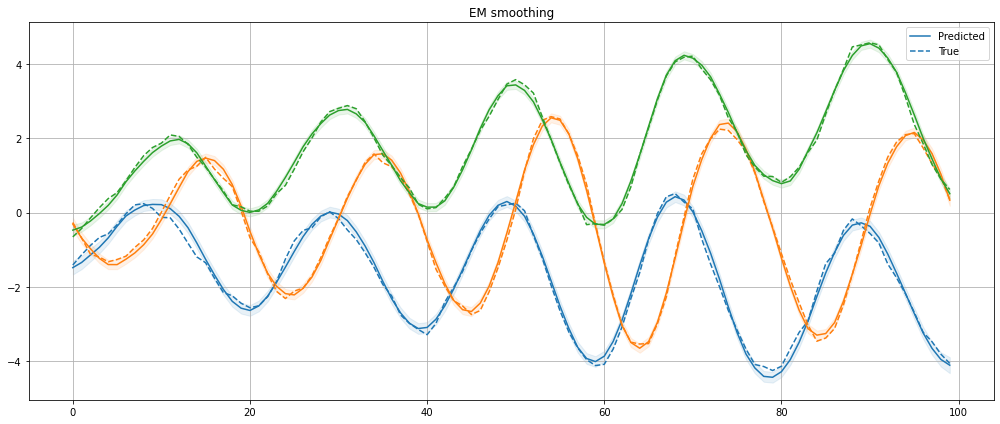

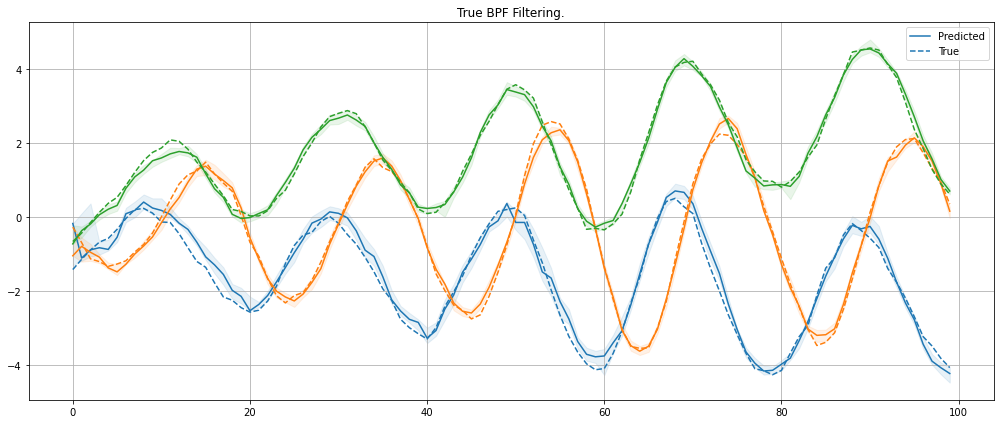

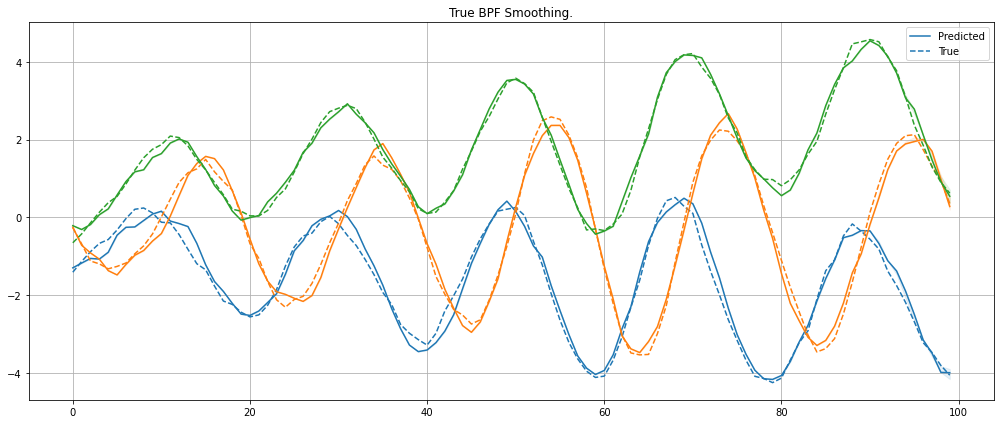

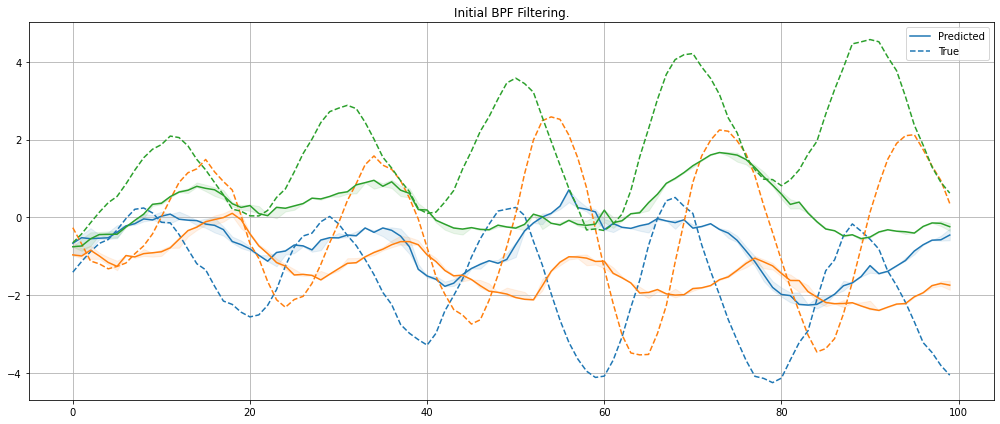

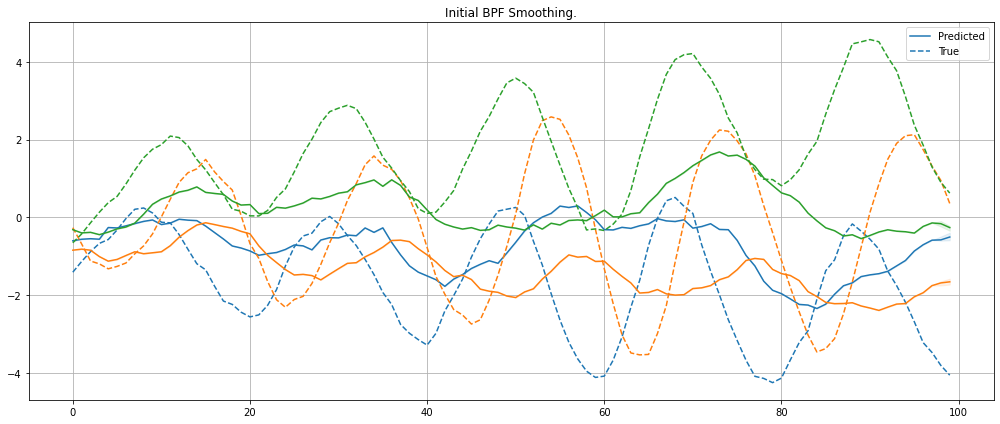

Initial BPF LML:  483.01395


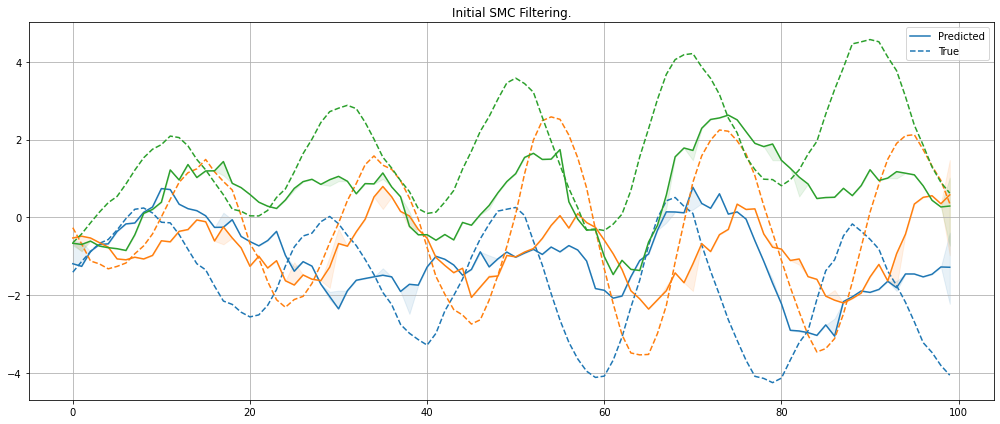

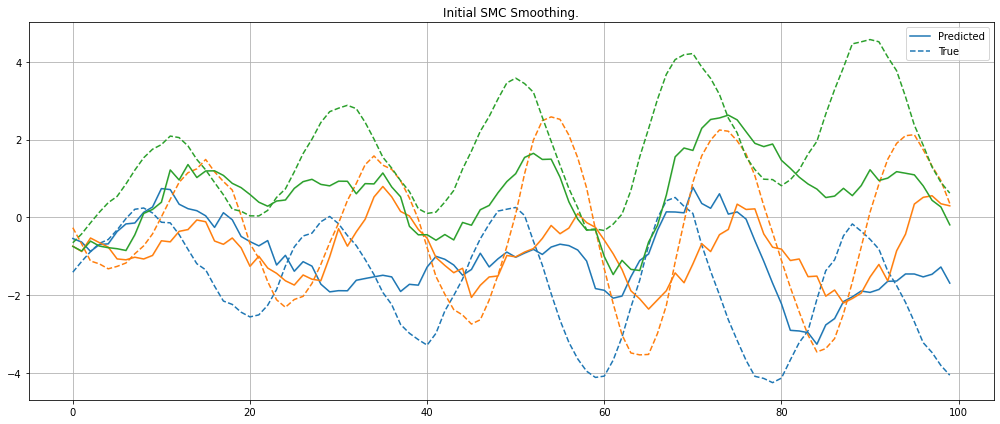

Step:     0,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML: 1359.015  Pred FIVO-bound: 3343.579
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.988     -0.030     -0.154      0.029      1.000     -0.007      0.154      0.003      0.988



In [10]:

def initial_validation(key, true_model, dataset, true_states, opt, _do_fivo_sweep_jitted, _smc_jit,
                       _num_particles=1000, _dset_to_plot=0, _init_model=None):
    """
    Do an test of the true model and the initialized model.
    :param key:
    :param true_model:
    :param dataset:
    :param true_states:
    :param opt:
    :param _do_fivo_sweep_jitted:
    :param _num_particles:
    :param _dset_to_plot:
    :return:
    """
    true_lml, em_log_marginal_likelihood = 0.0, 0.0

    # Test against EM (which for the LDS is exact).
    em_posterior = jax.vmap(true_model.e_step)(dataset)
    em_log_marginal_likelihood = true_model.marginal_likelihood(dataset, posterior=em_posterior)
    em_log_marginal_likelihood = - utils.lexp(em_log_marginal_likelihood)
    sweep_em_mean = em_posterior.mean()[_dset_to_plot]
    sweep_em_sds = np.sqrt(np.asarray([[np.diag(__k) for __k in _k] for _k in em_posterior.covariance()]))[_dset_to_plot]
    sweep_em_statistics = (sweep_em_mean, sweep_em_mean - sweep_em_sds, sweep_em_mean + sweep_em_sds)
    _plot_single_sweep(sweep_em_statistics, true_states[_dset_to_plot],
                       tag='EM smoothing', preprocessed=True, _obs=dataset[_dset_to_plot])

    # Test SMC in the true model..
    key, subkey = jr.split(key)
    smc_posterior = _smc_jit(subkey, true_model, len(dataset), dataset, num_particles=_num_particles)
    true_lml = - utils.lexp(smc_posterior.log_normalizer)
    _plot_single_sweep(smc_posterior[_dset_to_plot].filtering_particles,
                       true_states[_dset_to_plot],
                       tag='True BPF Filtering.',
                       _obs=dataset[_dset_to_plot])
    key, subkey = jr.split(key)
    _plot_single_sweep(smc_posterior[_dset_to_plot].sample(sample_shape=(_num_particles,), seed=subkey),
                       true_states[_dset_to_plot],
                       tag='True BPF Smoothing.',
                       _obs=dataset[_dset_to_plot])

    if _init_model is not None:
        # Test BPF in the initial model..
        key, subkey = jr.split(key)
        init_bpf_posterior = _smc_jit(subkey, _init_model, len(dataset), dataset, num_particles=_num_particles)
        initial_bpf_lml = - utils.lexp(init_bpf_posterior.log_normalizer)
        _plot_single_sweep(init_bpf_posterior[_dset_to_plot].filtering_particles,
                           true_states[_dset_to_plot],
                           tag='Initial BPF Filtering.',
                           _obs=dataset[_dset_to_plot])
        key, subkey = jr.split(key)
        _plot_single_sweep(init_bpf_posterior[_dset_to_plot].sample(sample_shape=(_num_particles,), seed=subkey),
                           true_states[_dset_to_plot],
                           tag='Initial BPF Smoothing.',
                           _obs=dataset[_dset_to_plot])
        print('Initial BPF LML: ', initial_bpf_lml)

    # Test SMC in the initial model.
    initial_params = dc(fivo.get_params_from_opt(opt))
    key, subkey = jr.split(key)
    initial_fivo_bound, sweep_posteriors = _do_fivo_sweep_jitted(subkey, fivo.get_params_from_opt(opt),
                                                                 _num_particles=_num_particles,
                                                                 _num_datasets=len(dataset),
                                                                 _datasets=dataset)
    initial_lml = -utils.lexp(sweep_posteriors.log_normalizer)

    filt_fig = _plot_single_sweep(sweep_posteriors[_dset_to_plot].filtering_particles,
                                  true_states[_dset_to_plot],
                                  tag='Initial SMC Filtering.',
                                  _obs=dataset[_dset_to_plot])
    key, subkey = jr.split(key)
    sweep_fig = _plot_single_sweep(sweep_posteriors[_dset_to_plot].sample(sample_shape=(_num_particles,), seed=subkey),
                                   true_states[_dset_to_plot],
                                   tag='Initial SMC Smoothing.',
                                   _obs=dataset[_dset_to_plot])

    # Do some print.
    lds_do_print(0, true_model, opt, true_lml, initial_lml, initial_fivo_bound, em_log_marginal_likelihood)
    return true_lml, em_log_marginal_likelihood, sweep_fig, filt_fig


# Test the initial models.
true_lml, em_log_marginal_likelihood, sweep_fig, filt_fig = \
    initial_validation(key, true_model, dataset[:num_val_datasets], true_states, opt, do_fivo_sweep_jitted, smc_jit,
                       _num_particles=50, _dset_to_plot=dset_to_plot, _init_model=model)

# 4. Do FIVO!

In [11]:
# Define some storage.
param_hist = [[], []]  # Model, proposal.
lml_hist = []
param_figures = [None, None, None]  # Loss, Model, proposal.


def log_params(_param_hist, _cur_params):
    """
    Short helper for logging the parameter values.
    """

    if _cur_params[0] is not None:
        _param_hist[0].append(_cur_params[0]._asdict())
    else:
        _param_hist[0].append(None)

    if _cur_params[1] is not None:
        _p = _cur_params[1]['params']._dict
        _p_flat = {}
        for _ko in _p.keys():
            for _ki in _p[_ko].keys():
                _k = _ko + '_' + _ki
                _p_flat[_k] = _p[_ko][_ki]
        _param_hist[1].append(_p_flat)
    else:
        _param_hist[1].append(None)

    return _param_hist

  0%|          | 0/10000 [00:00<?, ?it/s]

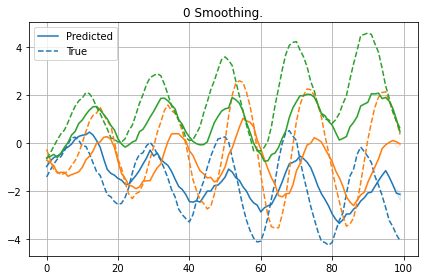

Step:     0,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  491.419  Pred FIVO-bound: 1895.013
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.987     -0.031     -0.153      0.028      0.999     -0.006      0.153      0.004      0.987



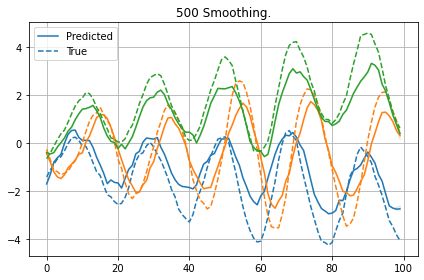

Step:   500,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  412.844  Pred FIVO-bound:  831.186
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.883     -0.183     -0.118      0.124      0.905      0.140      0.056     -0.116      0.897



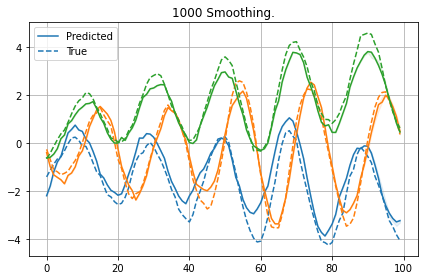

Step:  1000,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  402.880  Pred FIVO-bound:  556.479
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.874     -0.225     -0.110      0.184      0.947      0.205      0.034     -0.167      0.923



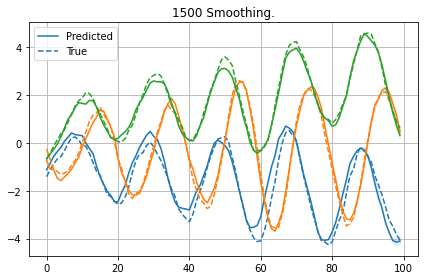

Step:  1500,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  396.530  Pred FIVO-bound:  476.508
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.889     -0.232     -0.108      0.200      0.967      0.220      0.016     -0.186      0.944



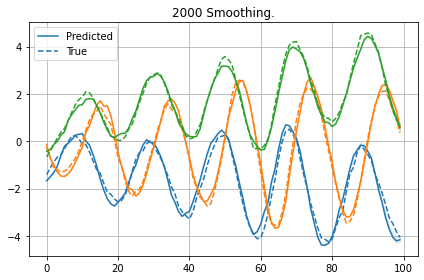

Step:  2000,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  395.613  Pred FIVO-bound:  449.254
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.904     -0.228     -0.107      0.208      0.973      0.220      0.009     -0.191      0.955



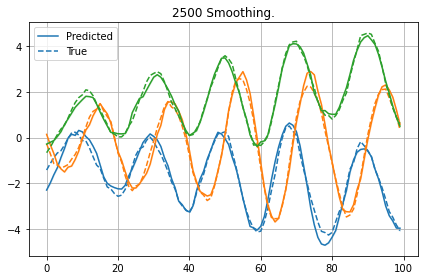

Step:  2500,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  394.756  Pred FIVO-bound:  432.972
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.920     -0.223     -0.097      0.217      0.976      0.217      0.009     -0.193      0.964



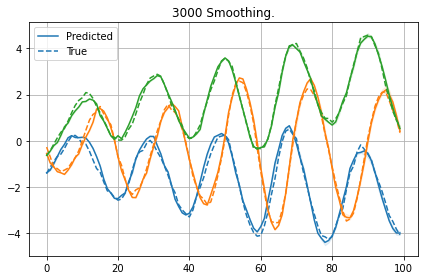

Step:  3000,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  394.558  Pred FIVO-bound:  430.229
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.925     -0.210     -0.091      0.222      0.972      0.218      0.013     -0.198      0.967



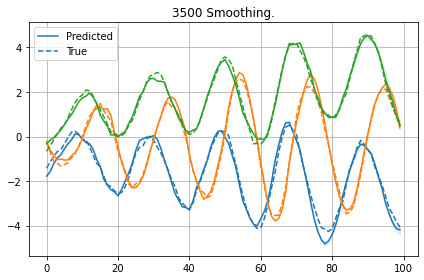

Step:  3500,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  394.155  Pred FIVO-bound:  426.260
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.932     -0.210     -0.087      0.228      0.971      0.219      0.016     -0.198      0.971



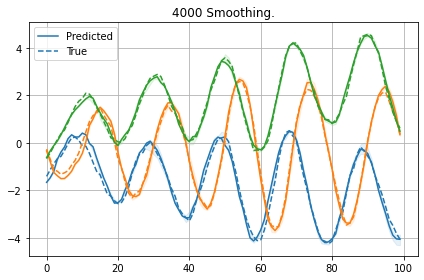

Step:  4000,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  395.299  Pred FIVO-bound:  424.534
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.935     -0.203     -0.085      0.236      0.969      0.218      0.017     -0.199      0.973



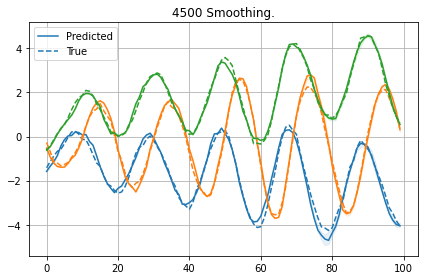

Step:  4500,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  393.194  Pred FIVO-bound:  423.354
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.942     -0.201     -0.081      0.236      0.968      0.219      0.019     -0.197      0.975



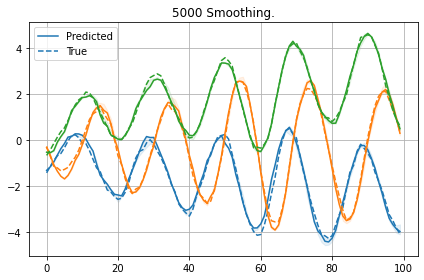

Step:  5000,  True Neg-LML:  394.419,  EM Neg-LML:  390.744  Pred Neg-LML:  393.586  Pred FIVO-bound:  422.616
True: dynamics:       0.973     -0.218     -0.069      0.228      0.952      0.204      0.022     -0.214      0.977
Pred: dynamics:       0.945     -0.196     -0.085      0.240      0.967      0.216      0.018     -0.203      0.976



In [ ]:
# Main training loop.
for _step in tqdm(range(opt_steps)):

    # Batch the data.
    key, subkey = jr.split(key)
    idx = jr.randint(key=subkey, shape=(datasets_per_batch, ), minval=0, maxval=len(dataset))
    batched_dataset = dataset.at[idx].get()

    # Do the sweep and compute the gradient.
    key, subkey = jr.split(key)
    cur_params = dc(fivo.get_params_from_opt(opt))
    (pred_fivo_bound, smc_posteriors), grad = do_fivo_sweep_val_and_grad(subkey,
                                                                         fivo.get_params_from_opt(opt),
                                                                         num_particles,
                                                                         len(batched_dataset),
                                                                         batched_dataset)
    pred_lml = - utils.lexp(smc_posteriors.log_normalizer)

    # Apply the gradient update.
    opt = fivo.apply_gradient(grad, opt, )

    # Log.
    lml_hist.append(dc(pred_lml))
    param_hist = log_params(param_hist, cur_params)

    # Do some validation and give some output.
    coldstart = 0
    if (_step % 500 == 0) or (_step < coldstart):
        pred_fivo_bound_to_print = pred_fivo_bound
        pred_lml_to_print = pred_lml

        if (_step > coldstart) or (_step == 0):
            key, subkey = jr.split(key)

            pred_fivo_bound_to_print, pred_sweep = do_fivo_sweep_jitted(subkey, fivo.get_params_from_opt(opt),
                                                                        _num_particles=validation_particles,
                                                                        _num_datasets=len(dataset[:num_val_datasets]),
                                                                        _datasets=dataset[:num_val_datasets])
            pred_lml_to_print = - utils.lexp(pred_sweep.log_normalizer)

            # filt_fig = _plot_single_sweep(pred_sweep[dset_to_plot].filtering_particles,
            #                               true_states[dset_to_plot],
            #                               tag='{} Filtering.'.format(_step),
            #                               fig=filt_fig,
            #                               _obs=dataset[dset_to_plot])
            sweep_fig = _plot_single_sweep(
                pred_sweep[dset_to_plot].sample(sample_shape=(num_particles,), seed=subkey),
                true_states[dset_to_plot],
                tag='{} Smoothing.'.format(_step),
                fig=sweep_fig,
                _obs=dataset[dset_to_plot])

            lds_do_print(_step,
                         true_model,
                         opt,
                         true_lml,
                         pred_lml_to_print,
                         pred_fivo_bound_to_print,
                         em_log_marginal_likelihood)
        # # NOTE - Uncomment this to enable more output for debugging.
        # else:
        #     lds_do_print(_step,
        #                  true_model,
        #                  opt,
        #                  true_lml,
        #                  pred_lml_to_print,
        #                  pred_fivo_bound_to_print,
        #                  em_log_marginal_likelihood)
        

param_figures = lds_do_plot(param_hist,
                            lml_hist,
                            em_log_marginal_likelihood,
                            true_lml,
                            get_model_free_params(true_model),
                            param_figures)
print('Done')



---
---